In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Now, we have to import our MNIST images. To do this, we’ll call a TF function called read_data_sets. This loads in the 55,000 training examples in the MNIST database. 

In [2]:
df = pd.read_csv('000300_2005_2019_1m.csv')
df.head()

,Unnamed: 0,open,close,high,low,volume,money
0,2005-04-08 09:31:00,984.66,983.83,984.66,983.66,19930000.0,214853842.0
1,2005-04-08 09:32:00,983.85,984.79,984.79,983.85,6780000.0,73091272.0
2,2005-04-08 09:33:00,984.50,984.84,984.86,984.44,4680000.0,27809568.0
3,2005-04-08 09:34:00,984.93,985.55,985.67,984.83,6150000.0,27162392.0
4,2005-04-08 09:35:00,985.64,986.37,986.37,985.64,6520000.0,27208928.0


In [3]:
C = np.array(df['close'])
Ret = (C[1:]-C[:-1])/C[:-1]

In [4]:
Ret = Ret[4:]

In [5]:
N = len(Ret)//25
l = 25
X = Ret.reshape(N,l)

In [6]:
train_size=int(N*0.8)

In [7]:
X_train = X[:train_size,:]
X_test = X[train_size:,:]
X_train.shape

(26204, 25)

In [8]:
def cum_ret(r):
    l=len(r)
    ts = np.ones(l+1)
    for i in range(l):
        ts[i+1:]*=(1+r[i])
    return ts

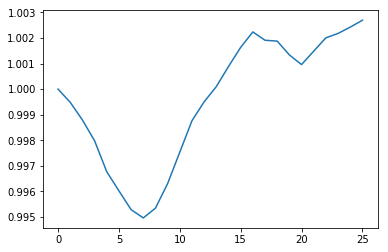

In [47]:
randomNum = random.randint(0,train_size)
r = X_train[randomNum]
ts=cum_ret(r)
plt.plot(ts)
plt.show()

# Discriminator Network

In [10]:
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [l, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y=tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y

# Generator Network

In [11]:
def generator(z,reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        W_fc1 = tf.get_variable('g_wfc1', [l, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('g_bfc1', [32], initializer=tf.constant_initializer(0))
        h_fc1 = tf.nn.relu(tf.matmul(z, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('g_wfc2', [32, l], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('g_bfc2', [l], initializer=tf.constant_initializer(0))
        y=tf.nn.tanh(tf.matmul(h_fc1, W_fc2) + b_fc2)

    return y

## Generating a Sample Image 

In [12]:
sess = tf.Session()
z_test_placeholder = tf.placeholder("float", [10,l])

In [13]:
sample_image = generator(z_test_placeholder)
test_z = np.random.normal(0, 1, [10,l])

In [14]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

Finally, we can view the output through matplotlib. 

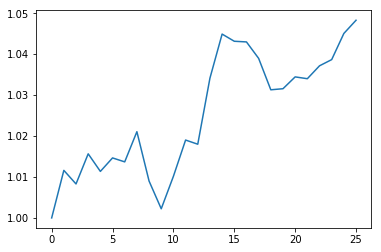

In [15]:
my_i = temp.squeeze()
plt.plot(cum_ret(my_i[5]))
plt.show()

# Training a GAN

In [16]:
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,l]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, l]) #Placeholder for input noise vectors to the generator

In [17]:
Dx = discriminator(x_placeholder) #Dx will hold discriminator outputs (unnormalized) for the real MNIST images
Gz = generator(z_placeholder) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator outputs (unnormalized) for generated images

In [18]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))  

In [19]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

In [20]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [21]:
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    trainerD = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
    trainerG = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [22]:
sess.run(tf.global_variables_initializer())
iterations = 1600
for i in range(iterations):
    z_batch = np.random.normal(0, 1, size=[batch_size, l])
    real_data_batch = X_train[i*batch_size:(i+1)*batch_size]
    
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_data_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator 

[[ 1.23707617 -0.04052303  0.03186588  0.09404731 -1.47742087 -0.69286486
  -0.05398242  0.43229613 -0.53277814 -0.28597743  0.92231396 -0.58954295
  -0.20459758  0.36595227  0.42332779 -0.71628644 -1.50917715  1.3003803
  -0.50684304 -0.5612709  -0.32612518  1.50964324  0.22144866 -0.46152152
   0.56868188]]


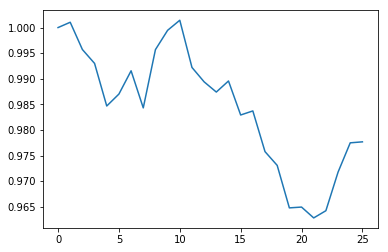

In [46]:
test_z = generator(z_placeholder,reuse=True)
z_batch = np.random.normal(0, 1, size=[1,l])
print(z_batch)
temp = (sess.run(test_z, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.plot(cum_ret(my_i))